In [ ]:
%autosave 60

Autosaving every 60 seconds


In [ ]:
%load_ext autoreload
%autoreload 2

# Лучший Результат  0.775252  - 1 место

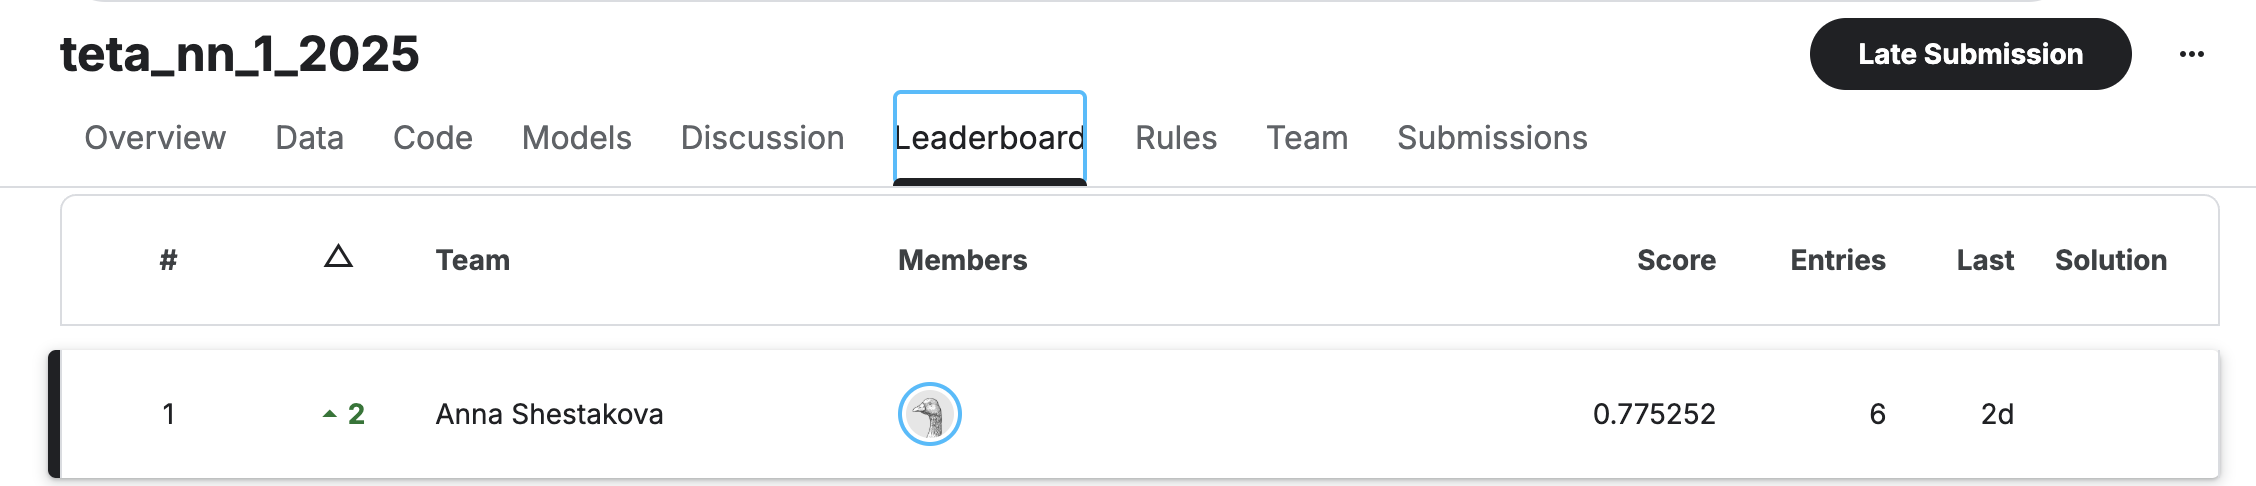

Шестакова Анна Анатольевна

https://www.kaggle.com/annexkova

### Intro к соревнованию "NN_1"

В рамках данного соревнования по предсказанию зарплат на основе описаний вакансий, я провела комплексный анализ данных, предобработку текстовых данных, а также обучила и настроила несколько моделей машинного обучения, включая самописные нейронные сети и модели на основе предобученных трансформеров. Целью было достичь наилучшего качества предсказаний, измеряемого метрикой R².

#### Анализ того, что пробовали

1. **Предобработка текстовых данных**:
   - Удаление HTML-тегов, спецсимволов и лишних пробелов.
   - Токенизация с использованием библиотеки `razdel`.
   - Лемматизация с помощью `pymorphy3`.
   - Удаление стоп-слов и шума (например, "компания", "требуется").
   - Обработка различных текстовых столбцов ("title", "location", "company", "skills", "description") с учетом специфики каждой колонки.

2. **Векторизация текстовых данных**:
   - Преобразование текста в числовые признаки с использованием TF-IDF для каждой колонки отдельно.
   - Объединение полученных матриц TF-IDF и числовых признаков (опыт работы) в единую разреженную матрицу.

3. **Самописные нейронные сети**:
   - Базовая нейронная сеть (`SalaryRegressor`) с простой последовательной архитектурой.
   - Улучшенная нейронная сеть (`SalaryRegressorImproved`) с использованием `LayerNorm`, `Residual Connections` и функцией активации `GELU`.
   - Нейронная сеть с добавлением механизма внимания (`SalaryRegressorWithAttention`).

4. **Оптимизация гиперпараметров**:
   - Использование `Optuna` для поиска оптимальных гиперпараметров для модели с вниманием.

5. **Дообучение предобученных моделей**:
   - Использование эмбеддингов модели `sergeyzh/rubert-mini-frida` для расширения признакового пространства.
   - Дообучение модели `sberbank-ai/ruBERT-tiny` с модифицированным классификатором для задачи регрессии.

6. **Ансамблирование**:
   - Создание ансамблей из различных моделей для улучшения качества предсказаний.

#### Анализ причин, что пошло не так (или что могло пойти не так, если всё было ок)

1. **Переобучение**:
   - В некоторых случаях модели могли переобучаться на тренировочных данных, особенно при увеличении сложности архитектуры или количества эпох обучения.

2. **Недостаточная предобработка данных**:
   - Некоторые аспекты предобработки, такие как удаление шума и специфические особенности вакансий, могли быть недостаточно тщательно продуманы, что могло повлиять на качество признаков.

3. **Неоптимальные гиперпараметры**:
   - Начальные значения гиперпараметров могли быть неоптимальными, что потребовало дополнительного поиска и настройки.

4. **Качество предобученных моделей**:
   - Качество предобученных моделей могло быть ограничено, особенно при использовании моделей с меньшим количеством параметров (например, `ruBERT-tiny`).

#### Анализ применимости вашего решения в бизнес-процессах

 **Автоматизация процесса оценки зарплат**:
   - Предсказания зарплат могут использоваться для анализа рыночных условий, определения трендов и прогнозирования спроса на различные профессии и навыки.

#### Outro

В результате выполнения задания были достигнуты хорошие результаты, однако всегда есть возможность для улучшения. В дальнейшем можно рассмотреть использование более мощных предобученных моделей, улучшение методов предобработки данных и эксперименты с другими архитектурами нейронных сетей. Надеюсь, что полученные знания и опыт помогут в будущих проектах по работе с текстовыми данными и прогнозированию.

Что интересно, победи ансамбль из 2 моделей: самописная SalaryRegressorWithAttention с эмбедингами frida_enhanced + ruBERT-tiny,
ансамбль из 3 моделей базовая самописная SalaryRegressorWithAttention + она же с эмбедингами frida_enhanced + ruBERT-tiny оказалась слабее


In [ ]:
# import torch
# import gc

# # Очищаем кэш MPS
# if hasattr(torch.cuda, 'empty_cache'):
#     torch.cuda.empty_cache()  # Не влияет на MPS, но безопасно вызвать
# torch.mps.empty_cache()  # Основной способ для освобождения памяти на MPS

# # Вызываем сборщик мусора
# gc.collect()

In [ ]:
# === 1. Системные и стандартные библиотеки ===
import os
import re
import gc
import warnings
from collections import Counter
from functools import lru_cache

# === 2. Научные и вычислительные библиотеки ===
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# === 3. Визуализация ===
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from graphviz import Digraph

# === 4. Прогресс-бары и логирование ===
from tqdm.notebook import tqdm  # Используй `tqdm.auto` если в CLI
import logging

# === 5. SKlearn и ML ===
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, f1_score, accuracy_score,
    r2_score, mean_squared_error, mean_absolute_error
)
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.sparse import hstack, csr_matrix

# === 6. NLP и обработка текста ===
import nltk
from nltk.corpus import stopwords
import pymorphy3
from razdel import tokenize as razdel_tokenize

# === 7. Transformers и Hugging Face ===
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoImageProcessor,
    AutoFeatureExtractor,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    ConvNextV2Model,
    ConvNextV2Config,
)
from datasets import Dataset as HFDataset

# === 8. Константы и настройка среды ===
# Подавление предупреждений
warnings.filterwarnings('ignore')
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

# Глобальные константы
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Определяем устройство: MPS (Apple Silicon GPU), CUDA или CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.manual_seed(RANDOM_STATE)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(RANDOM_STATE)
else:
    device = torch.device("cpu")

print(f"✅ Используемое устройство: {device}")

# --- Инициализация лидерборда ---
leaderboard = pd.DataFrame(columns=['Метод', 'R2_Score'])

✅ Используемое устройство: cuda


# Загрузка и базовая предобработка

1.Разделение данных на train/val

2. Подготовка обработанной версии данных специально для PyTorch:

3. Текстовые признаки в TF-IDF

4. Числовые признаки

5. Подготовка датасета для PyTorch

6. Построение модели: нейросеть из нескольких Linear слоев:

        При этом будет обучено несколько нейросетей с возрастающей сложностью

8. Обучение модели с кросс-валидацией (5 фолдов, 10 эпох)

Вывод: R² на каждом фолде + итоговая оценка



### Загрузка и первичный анализ
- Загрузим данные из train.csv и test.csv.
- Проверим на пропуски, дубликаты, аномалии.
- Изучим распределение целевой переменной log_salary_from.

In [ ]:
# Загружаем данные из файлов соревнования

full_train_df = pd.read_csv('teta-nn-1-2025/train.csv')
test_df = pd.read_csv('teta-nn-1-2025/test.csv')



# Разбиваем исходный train на обучающую и валидационную выборки
train_df, val_df = train_test_split(
    full_train_df,
    test_size=0.20,
    random_state=RANDOM_STATE
)


# Сбрасываем индексы для удобства
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


# Создаем единое текстовое поле для анализа
text_cols = ['title', 'location', 'company', 'skills', 'description']
for df in [train_df, val_df, test_df]:
    # Заполняем пропуски пустыми строками, чтобы избежать ошибок
    df[text_cols] = df[text_cols].fillna('')


In [ ]:
# Выведем первые 3 строки трейна для проверки
train_df.head(3)

,title,location,company,skills,description,experience_from,salary_from,log_salary_from
0,Главный специалист по пожарной безопасности,Петропавловск-Камчатский,Почта России,"Пожарная безопасность, Технические системы и с...",Обязанности: ​​​​​​оценивать возможность (...,1.0,100.0,4.605170
1,Frontend-разработчик (Vue),Москва,Ассоциация IPChain,,Проект: ScaleIT - онлайн-сервис для создани...,3.0,200.0,5.298317
2,Помощник дизайнера интерьера,Москва,Buro 315,"Adobe Photoshop, AutoCAD, MS Excel, Autodesk R...","В связи с увеличением объема работы, требуется...",1.0,70.0,4.248495


In [ ]:
train_df.shape, val_df.shape, test_df.shape

((13333, 8), (3334, 8), (5556, 6))

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13333 entries, 0 to 13332
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            13333 non-null  object 
 1   location         13333 non-null  object 
 2   company          13333 non-null  object 
 3   skills           13333 non-null  object 
 4   description      13333 non-null  object 
 5   experience_from  13333 non-null  float64
 6   salary_from      13333 non-null  float64
 7   log_salary_from  13333 non-null  float64
dtypes: float64(3), object(5)
memory usage: 833.4+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5556 entries, 0 to 5555
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            5556 non-null   object 
 1   location         5556 non-null   object 
 2   company          5556 non-null   object 
 3   skills           5556 non-null   object 
 4   description      5556 non-null   object 
 5   experience_from  5556 non-null   float64
dtypes: float64(1), object(5)
memory usage: 260.6+ KB


### Проверка дубликатов

In [ ]:
print(f"Дубликатов в трейне: {train_df.duplicated().sum()}")
print(f"Дубликатов в тесте: {test_df.duplicated().sum()}")

Дубликатов в трейне: 0
Дубликатов в тесте: 0


### Анализ целевой переменной log_salary_from

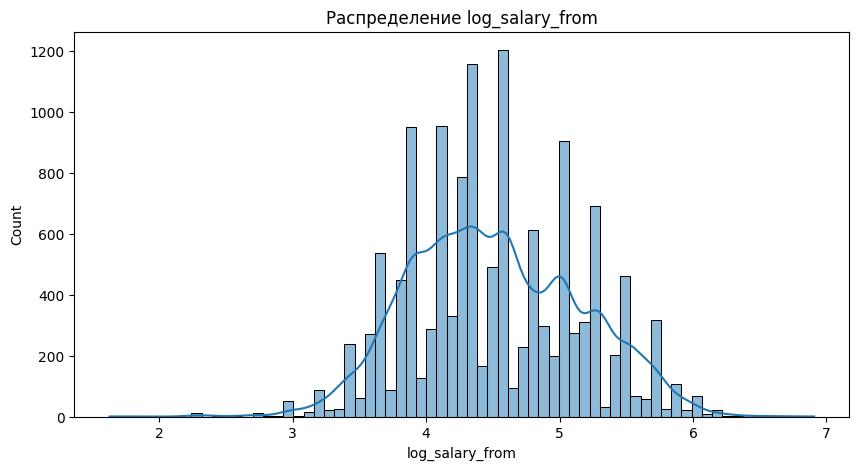

count    13333.000000
mean         4.515410
std          0.632041
min          1.629241
25%          4.094345
50%          4.499810
75%          5.010635
max          6.907755
Name: log_salary_from, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(train_df['log_salary_from'], kde=True)
plt.title("Распределение log_salary_from")
plt.show()

# Описательная статистика
print(train_df['log_salary_from'].describe())

Аномалий и выбросов нет.

### Анализ текстовых колонок
Проверим длину текстов (может быть пустой description или слишком длинный):

In [ ]:
# Длина description в символах
train_df['desc_len'] = train_df['description'].apply(len)
print(train_df['desc_len'].describe())

count    13333.000000
mean      1764.057526
std        857.373461
min        164.000000
25%       1167.000000
50%       1644.000000
75%       2212.000000
max       9439.000000
Name: desc_len, dtype: float64


1. Средняя длина описания - 1764 символа
2. Максимальная длина - 9439 символов (очень длинное описание)
   
Для моделей с ограничением на длину текста (например, BERT - 512 токенов,(примерно 300-400 слов для русского языка) у ruBERT так же), поэтому в процессе обучения модели  такие строки будут обрезаны.


## 🧹 1. Предобработка (препроцессинг) текста
## . Обработка датафрейма с предобработкой текстов


### 🎯 Цель
Преобразовать "сырые" тексты вакансий в чистый, нормализованный вид, чтобы нейросеть могла эффективно извлекать признаки, **не теряя важной семантики**.


### 🧩 Пайплайн обработки

1. **`clean_text`**: удаляет HTML, спецсимволы, лишние пробелы.
2. **`preprocess_text`**:
   - Токенизация (`razdel`)  — он корректно работает с русскими сокращениями (`т.д.`, `г.`).
   - Фильтрация по алфавиту
   - (Опционально) лемматизация (`pymorphy3`) - `pymorphy3` приводит слова к нормальной форме (`работая` → `работать`).
   - Удаление стоп-слов -  общие (`и`, `на`) и вакансионный шум (`компания`, `требуется`).
   - Объединение в строку


---

### ⚙️ Особенности для разных колонок

| Колонка | Особенность | Как реализовано |
|--------|------------|----------------|
| **`title`** | Сохраняем регистр (`Python`, `C++`) | `lowercase=False` |
| **`skills`** | Разделяем по запятым, не лемматизируем | `preprocess_skills()` — обработка без лемматизации |
| **`description`** | Полная обработка: очистка + лемматизация | `preprocess_text()` с `lemmatize=True` |
| **`location`, `company`** | Удаляем шум (`м.`, `ООО`) | Обработаны как `description` |


Почему `skills` без лемматизации?  
Чтобы не потерять `C++` → `c` или `React` → `реакт`. Здесь важны **точные названия технологий**.


---

Обработка числовых признаков (в данных датасетах нет числовых пропусков, но если придет тест с пропусками, их необходимо было бы обработать)
- **`experience_from`**: заполняем пропуски **медианой из `train`**
- **`has_experience`**: бинарный признак — был ли пропуск (может быть сигналом)

```

In [ ]:
# 1. Загрузка стоп-слов
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('russian'))
# Дополнительные стоп-слова для вакансий
stop_words.update([
    'наш', 'компания', 'команда', 'работа', 'вакансия',
    'искать', 'требуется', 'обязанность', 'ооо', 'зао',
    'групп', ' ltd', 'inc', 'llc', 'гк', 'plc', ' ltd'
])


# 2. Инициализация лемматизатора
morph = pymorphy3.MorphAnalyzer()

# 3. Функции предобработки


In [ ]:
# 1. Загрузка стоп-слов
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('russian'))
# Дополнительные стоп-слова для вакансий
stop_words.update([
    'наш', 'компания', 'команда', 'работа', 'вакансия',
    'искать', 'требуется', 'обязанность', 'ооо', 'зао',
    'групп', ' ltd', 'inc', 'llc', 'гк', 'plc', ' ltd'
])


# 2. Инициализация лемматизатора
morph = pymorphy3.MorphAnalyzer()


# 3. Функции предобработки
def clean_text(text: str) -> str:
    """Очистка текста от HTML-тегов и спецсимволов."""
    if not isinstance(text, str) or pd.isna(text):
        return ""
    # Удаляем HTML-теги
    text = re.sub(r'<[^>]+>', '', text)
    # Оставляем только буквы, цифры и пробелы
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ0-9\s]', ' ', text)
    # Удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_text(text: str, lowercase: bool = True, lemmatize: bool = True) -> str:
    """
    Общая функция обработки текста.
    Параметры:
    - lowercase: приводить к нижнему регистру
    - lemmatize: применять лемматизацию
    """
    text = clean_text(text)
    tokens = [token.text for token in razdel_tokenize(text)]
    # Фильтрация по алфавиту: используем .text.isalpha()
    tokens = [t for t in tokens if t.isalpha()]

    if lowercase:
        tokens = [t.lower() for t in tokens]

    if lemmatize:
        lemmas = [morph.parse(t)[0].normal_form for t in tokens]
        cleaned = [lemma for lemma in lemmas if lemma not in stop_words]
    else:
        cleaned = [t for t in tokens if t not in stop_words]

    return " ".join(cleaned)

def preprocess_skills(skills: str) -> str:
    """
    Обработка колонки skills: разделяем по запятым, обрабатываем каждую часть.
    Сохраняем ключевые навыки (C++, Python) без лемматизации.
    """
    if not isinstance(skills, str) or pd.isna(skills):
        return ""
    # Разделяем по запятым
    skill_list = [s.strip() for s in skills.split(',') if s.strip()]
    processed = []
    for skill in skill_list:
        cleaned = clean_text(skill)
        # Исправлено: t.text.isalpha() — не t.isalpha()
        tokens = [t.text for t in razdel_tokenize(cleaned) if t.text.isalpha()]
        tokens = [t.lower() for t in tokens]  # в нижний регистр
        processed.extend(tokens)
    # Удаляем стоп-слова
    cleaned_skills = [w for w in processed if w not in stop_words]
    return " ".join(cleaned_skills)


# 4. Обработка experience_from и has_experience
# Вычисляем медиану ТОЛЬКО по train_df
exp_median = full_train_df['experience_from'].median()

# Применяем ко ВСЕМ датасетам
for df in [train_df, val_df, test_df]:
    df['experience_from'] = df['experience_from'].fillna(exp_median)
    df['has_experience'] = df['experience_from'].notna().astype(int)


# 5. Активируем tqdm для pandas
tqdm.pandas(desc="Processing")


# 6. Обработка ВСЕХ текстовых колонок
text_columns = ['title', 'location', 'company', 'description']

# Обработка для train_df
for col in text_columns:
    print(f"🔄 Обработка колонки '{col}' в train_df...")
    train_df[f'{col}_processed'] = train_df[col].progress_apply(
        lambda x: preprocess_text(x, lowercase=(col != 'title'), lemmatize=True)
    )

# Обработка для val_df
for col in text_columns:
    print(f"🔄 Обработка колонки '{col}' в val_df...")
    val_df[f'{col}_processed'] = val_df[col].progress_apply(
        lambda x: preprocess_text(x, lowercase=(col != 'title'), lemmatize=True)
    )

# Обработка для test_df
for col in text_columns:
    print(f"🔄 Обработка колонки '{col}' в test_df...")
    test_df[f'{col}_processed'] = test_df[col].progress_apply(
        lambda x: preprocess_text(x, lowercase=(col != 'title'), lemmatize=True)
    )

# Обработка skills отдельно (без лемматизации)
print("🔧 Обработка skills в train_df...")
train_df['skills_processed'] = train_df['skills'].progress_apply(preprocess_skills)

print("🔧 Обработка skills в val_df...")
val_df['skills_processed'] = val_df['skills'].progress_apply(preprocess_skills)

print("🔧 Обработка skills в test_df...")
test_df['skills_processed'] = test_df['skills'].progress_apply(preprocess_skills)



🔄 Обработка колонки 'title' в train_df...


Processing:   0%|          | 0/13333 [00:00<?, ?it/s]

🔄 Обработка колонки 'location' в train_df...


Processing:   0%|          | 0/13333 [00:00<?, ?it/s]

🔄 Обработка колонки 'company' в train_df...


Processing:   0%|          | 0/13333 [00:00<?, ?it/s]

🔄 Обработка колонки 'description' в train_df...


Processing:   0%|          | 0/13333 [00:00<?, ?it/s]

🔄 Обработка колонки 'title' в val_df...


Processing:   0%|          | 0/3334 [00:00<?, ?it/s]

🔄 Обработка колонки 'location' в val_df...


Processing:   0%|          | 0/3334 [00:00<?, ?it/s]

🔄 Обработка колонки 'company' в val_df...


Processing:   0%|          | 0/3334 [00:00<?, ?it/s]

🔄 Обработка колонки 'description' в val_df...


Processing:   0%|          | 0/3334 [00:00<?, ?it/s]

🔄 Обработка колонки 'title' в test_df...


Processing:   0%|          | 0/5556 [00:00<?, ?it/s]

🔄 Обработка колонки 'location' в test_df...


Processing:   0%|          | 0/5556 [00:00<?, ?it/s]

🔄 Обработка колонки 'company' в test_df...


Processing:   0%|          | 0/5556 [00:00<?, ?it/s]

🔄 Обработка колонки 'description' в test_df...


Processing:   0%|          | 0/5556 [00:00<?, ?it/s]

🔧 Обработка skills в train_df...


Processing:   0%|          | 0/13333 [00:00<?, ?it/s]

🔧 Обработка skills в val_df...


Processing:   0%|          | 0/3334 [00:00<?, ?it/s]

🔧 Обработка skills в test_df...


Processing:   0%|          | 0/5556 [00:00<?, ?it/s]

In [ ]:

# Проверка результата

print("\n✅ Примеры обработки:")

print("\nTitle:")
print("Оригинал:   ", train_df['title'].iloc[0])
print("Обработано: ", train_df['title_processed'].iloc[0])

print("\nSkills:")
print("Оригинал:   ", train_df['skills'].iloc[0])
print("Обработано: ", train_df['skills_processed'].iloc[0])

print("\nDescription:")
print("Оригинал:   ", train_df['description'].iloc[0][:100], "...")
print("Обработано: ", train_df['description_processed'].iloc[0][:100], "...")


✅ Примеры обработки:

Title:
Оригинал:    Главный специалист по пожарной безопасности
Обработано:  главный специалист пожарный безопасность

Skills:
Оригинал:    Пожарная безопасность, Технические системы и средства безопасности, Тестирование безопасности, Разработка внутренней документации
Обработано:  пожарная безопасность технические системы средства безопасности тестирование безопасности разработка внутренней документации

Description:
Оригинал:    Обязанности:     ​​​​​​оценивать возможность (риски) возникновения пожара, а также степень возможног ...
Обработано:  оценивать возможность риск возникновение пожар также степень возможный воздействие опасный фактор че ...


In [ ]:
# Сохраняем результат в файл
train_df.to_pickle("train_df_processed.pkl")

In [ ]:
# Загружаем при следующем запуске, чтобы не обрабатывать заново
# В начале ноутбука (после импорта pandas):

# import pandas as pd
# import os

# # Если файл уже есть — загружаем, иначе обрабатываем заново
# if os.path.exists("train_df_processed.pkl"):
#     print("Загружаем сохранённый предобработанный датафрейм...")
#     train_df = pd.read_pickle("train_df_processed.pkl")
# else:
#     print("Обрабатываем заново...")
#     # тут блок предобработки текстов (тот, что ты прислала)


### Создание двух версий данных

In [ ]:
# Копии, чтобы не сломать данные
df_for_pytorch = train_df.copy()
df_for_pytorch['title'] = df_for_pytorch['title_processed']
df_for_pytorch['description'] = df_for_pytorch['description_processed']
df_for_pytorch['skills'] = df_for_pytorch['skills_processed']
df_for_pytorch['location'] = df_for_pytorch['location_processed']
df_for_pytorch['company'] = df_for_pytorch['company_processed']

df_for_bert = train_df.copy()  # Если буду использовать ruBERT потом

# 2. Векторизация val и test

In [ ]:
# Векторизация val
X_val_tfidf = []
for col, vectorizer in vectorizers.items():
    vec = vectorizer.transform(val_df[f'{col}_processed'])  # только transform!
    X_val_tfidf.append(vec)
X_val_sparse = hstack(X_val_tfidf)

# Векторизация test
X_test_tfidf = []
for col, vectorizer in vectorizers.items():
    vec = vectorizer.transform(test_df[f'{col}_processed'])  # только transform!
    X_test_tfidf.append(vec)
X_test_sparse = hstack(X_test_tfidf)

# Стандартизация experience_from
X_val_num = scaler.transform(val_df[['experience_from']])        # scaler уже обучен на train
X_test_num = scaler.transform(test_df[['experience_from']])

# Создание X_val_all и X_test_all
X_val_all = hstack([X_val_sparse, csr_matrix(X_val_num)])
X_test_all = hstack([X_test_sparse, csr_matrix(X_test_num)])

print("X_val_all:", X_val_all.shape)      # (3334, 10008)
print("X_test_all:", X_test_all.shape)    # (5556, 10008)

X_val_all: (3334, 10008)
X_test_all: (5556, 10008)


# 3. TF-IDF по каждому полю отдельно

TF-IDF = Term Frequency – Inverse Document Frequency

Это способ преобразовать текст в числа , чтобы нейросеть или другая модель могла его понять.

TF-IDF даёт каждому слову вес , который показывает:
Насколько часто слово встречается в документе → TF (Term Frequency)
Насколько это слово редкое в целом по всем документам → IDF (Inverse Document Frequency)


✅ Например нас 1000 вакансий:

Слово "работа" встречается почти везде → неинформативное → низкий вес
Слово "C++" встречается только в 10 вакансиях → очень редкое → высокий вес

TF-IDF автоматически понижает вес частых слов и повышает вес редких.



In [ ]:
# Улучшенные параметры для всех векторизаторов (если не переопределены отдельно)
tfidf_params_base = dict(
    ngram_range=(1, 2),        # Используем униграммы (слова) и биграммы (пары слов)
                               # Например: "Python разработчик" будет как "python" и "python разработчик"
                               # Это помогает захватить составные названия технологий и должностей

    sublinear_tf=True,         # Применяет log(1 + tf) к частоте слова
                               # Уменьшает влияние слов, которые слишком часто повторяются в одном документе
                               # (например, "разработка" встречается 10 раз в описании → не значит, что в 10 раз важнее)

    max_df=0.95,               # Игнорируем слова, которые встречаются более чем в 95% вакансий
                               # Такие слова — шум: "работа", "компания", "вакансия", "требуется"
                               # Они не помогают отличить одну вакансию от другой

    min_df=2,                  # Игнорируем слова, которые встречаются реже чем в 2 вакансиях
                               # Убирает опечатки, редкие ошибки и уникальные слова, не несущие общей информации
)

# Создаём отдельный векторизатор для каждой текстовой колонки
# Это позволяет сохранить семантику: "Python" в названии ≠ "Python" в описании
vectorizers = {
    # Название вакансии — кратко, но информативно
    # Часто содержит ключевые технологии и уровень (Junior, Senior)
    'title': TfidfVectorizer(
        max_features=2500,     # Берём топ-2500 самых информативных слов/биграмм
        **tfidf_params_base    # Используем базовые настройки
    ),

    # Местоположение — влияет на зарплату (Москва vs. Барнаул)
    'location': TfidfVectorizer(
        max_features=1500,     # Меньше фич — локаций не так много
        **tfidf_params_base
    ),

    # Компания — тоже влияет на уровень зарплаты
    'company': TfidfVectorizer(
        max_features=1500,     # Много компаний, но не все информативны
        **tfidf_params_base
    ),

    # Навыки — самые важные признаки для зарплаты
    'skills': TfidfVectorizer(
        max_features=1500,     # Ограничиваем, но оставляем место для редких технологий (Kotlin, Airflow)
        ngram_range=(1, 1),    # Только отдельные слова!
                               # "Python Django" — это два навыка, а не одна фраза
                               # Биграммы здесь не нужны и могут навредить

        sublinear_tf=True,     # Смягчаем влияние частых навыков (например, "Python" в 1000 вакансиях)
        max_df=0.95,           # Убираем слишком частые: "опыт", "работа", "знания"
        min_df=1,              # Можно оставить даже 1 вхождение — навыки бывают редкими и важными
    ),

    # Описание — самый длинный и информативный текст
    # Содержит обязанности, требования, условия
    'description': TfidfVectorizer(
        max_features=4000,     # Максимум фич — много информации
        ngram_range=(1, 2),    # Биграммы важны: "работа с данными", "опыт в ML"
        sublinear_tf=True,     # Защита от "переспама" слов
        max_df=0.95,           # Убираем шум: "мы", "компания", "предлагаем"
        min_df=2,              # Игнорируем редкие слова (опечатки, уникальные формулировки)
    ),
}

In [ ]:
# Обучение векторизаторов и сборка общей матрицы признаков

# Список для хранения разреженных матриц от каждого векторизатора
X_tfidf = []

# Обучаем каждый векторизатор на своей колонке и добавляем результат
for col, vectorizer in vectorizers.items():
    print(f"✅ Векторизация: {col}")  # Показываем прогресс
    vec = vectorizer.fit_transform(df_for_pytorch[col])  # Обучаем и преобразуем текст в TF-IDF
    X_tfidf.append(vec)  # Добавляем матрицу в список

# Объединяем все TF-IDF матрицы по признакам (горизонтально)
# Важно: порядок признаков сохраняется — модель поймёт, откуда слово
X_sparse = hstack(X_tfidf)

# Добавляем и стандартизируем числовой признак: опыт работы
X_num = df_for_pytorch[['experience_from']].values  # Извлекаем как numpy
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

X_all = hstack([X_sparse, csr_matrix(X_num_scaled)])       # Добавляем как последний признак

# Целевая переменная — логарифм зарплаты (лучше распределение)
y_all = df_for_pytorch['log_salary_from'].values

# --- Диагностика ---
print("Размерность X_all:", X_all.shape)
# Показывает: (число вакансий, общее число признаков)
# Хорошо: 8000–15000 признаков. Слишком много → переобучение, слишком мало → недообучение

print("Sparsity: {:.4f}".format(X_all.nnz / (X_all.shape[0] * X_all.shape[1])))
# Плотность разреженной матрицы: доля ненулевых элементов
# Хорошо: 0.01–0.05 (1–5%). Это означает, что большинство признаков — нули (нормально для TF-IDF)

✅ Векторизация: title
✅ Векторизация: location
✅ Векторизация: company
✅ Векторизация: skills
✅ Векторизация: description
Размерность X_all: (13333, 10008)
Sparsity: 0.0148


In [ ]:
# СОХРАНЕНИЕ ДЛЯ ИНФЕРЕНСА
import joblib
joblib.dump(vectorizers, 'vectorizers.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Векторизаторы и scaler сохранены в 'vectorizers.pkl' и 'scaler.pkl'")

# 4. Cross-validation: 5-fold

    Унас есть отложеная выбока val_df.
    Но обучение будет происходить на тренировочной части (train_df) с помощию кросс-валидации на 5 фолдах.
    val_df будет использоваться для проверки модели перед финальным инференсом на тесте

In [ ]:
RANDOM_STATE = 42

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

#  5. Dataset для PyTorch

In [ ]:
# PyTorch Dataset
class SalaryDataset(Dataset):
    def __init__(self, X, y=None, exp_mean=None, exp_std=None):
        self.X = X
        self.y = y
        self.exp_mean = exp_mean
        self.exp_std = exp_std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx].toarray().squeeze()  # csr → numpy
        # Нормализуем experience_from (последний признак)
        if self.exp_mean is not None and self.exp_std is not None:
            x[-1] = (x[-1] - self.exp_mean) / (self.exp_std + 1e-8)  # защита от 0
        x_tensor = torch.tensor(x, dtype=torch.float32)
        if self.y is not None:
            y_tensor = torch.tensor(self.y[idx], dtype=torch.float32)
            return x_tensor, y_tensor
        return x_tensor

# 6. Самописные архитектуры нейронных сетей и их обучение

Универсальная функция train_crossval_model : вынесем весь процесс обучения и валидации в универсальную функцию, в которую можно передавать: любую модель (например, SalaryRegressor, SalaryRegressorImproved, и т.п.)


In [ ]:
# Обучение по фолдам
def train_crossval_model(ModelClass, input_dim, X_all, y_all, kf,
                         n_epochs=10, lr=1e-3, batch_size=256):
    r2_scores = []
    models = []
    criterion = nn.MSELoss()

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_all), 1):
        print(f"\n--- Обучение фолда {fold} из {kf.get_n_splits()} ---")

        # Разделение данных
        X_train, X_val = X_all[train_idx], X_all[val_idx]
        y_train = y_all[train_idx]
        y_val = y_all[val_idx]

        # Нормализация experience_from по train
        exp_col_train = X_train[:, -1].toarray().flatten()
        exp_mean = exp_col_train.mean()
        exp_std = exp_col_train.std()
        if exp_std == 0:
            exp_std = 1.0

        # Датасеты
        train_ds = SalaryDataset(X_train, y_train, exp_mean, exp_std)
        val_ds = SalaryDataset(X_val, y_val, exp_mean, exp_std)

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size)

        # Модель
        model = ModelClass(input_dim=input_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=2
        )

        best_val_r2 = -np.inf
        best_val_loss = float('inf')

        # Обучение
        for epoch in range(1, n_epochs + 1):
            # Обучение
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()

            # Валидация
            model.eval()
            val_preds = []
            val_losses = []
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    preds = model(xb)
                    loss = criterion(preds, yb)
                    val_losses.append(loss.item())
                    val_preds.extend(preds.cpu().numpy())

            val_r2 = r2_score(y_val, val_preds)
            val_loss = np.mean(val_losses)
            scheduler.step(val_r2)

            if val_r2 > best_val_r2:
                best_val_r2 = val_r2
                best_val_loss = val_loss

        r2_scores.append(best_val_r2)
        models.append(model)

        # ✅ Вывод результата по фолду (без прогресс-бара)
        print(f"✅ Фолд {fold} завершен: Лучший R²: {best_val_r2:.4f}, Loss: {best_val_loss:.4f}")

    # Итог
    mean_r2 = np.mean(r2_scores)
    print(f"\n📊 Среднее R² по {kf.get_n_splits()} фолдам: {mean_r2:.4f} {r2_scores}")

    return r2_scores, models

## 6.1 Базовая  нейросеть (первая)

Ключевые особенности:  
1. **Простая последовательная архитектура** (`nn.Sequential`) – без сложных элементов вроде residual-связей или нормализации.  
2. **ReLU** – стандартная функция активации после каждого полносвязного слоя.  
3. **Постепенное уменьшение размерности** (512 → 128 → 1) – классический подход для регрессии.  
4. **Dropout для регуляризации** – более сильный (0.3) на первом слое и слабее (0.2) на втором.  
5. **Отсутствие BatchNorm/LayerNorm** – может хуже работать с данными, требующими нормализации.  
6. **`.squeeze(1)` в конце** – удаляет лишнюю размерность для совместимости с форматом целевой переменной.  

Эта сеть – минималистичный вариант для регрессии, без "наворотов", но с базовой защитой от переобучения (Dropout). Мы ее берем как стартовую модель для сравнения с более сложными архитектурами, которые будем использовать дальше.

```
Input ➝ Linear (512) ➝ ReLU ➝ Dropout (0.3)  
        ➝ Linear (128) ➝ ReLU ➝ Dropout (0.2)  
        ➝ Linear (1) ➝ Output  
```

In [ ]:
class SalaryRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze(1)


In [ ]:
# Простой baseline
r2_scores, trained_models = train_crossval_model(
    SalaryRegressor,
    input_dim=X_all.shape[1],
    X_all=X_all,
    y_all=y_all,
    kf=kf,
    n_epochs=10,
    lr=1e-3,
    batch_size=256
)


--- Обучение фолда 1 из 5 ---
✅ Фолд 1 завершен: Лучший R²: 0.4375, Loss: 0.2218

--- Обучение фолда 2 из 5 ---
✅ Фолд 2 завершен: Лучший R²: 0.4557, Loss: 0.2149

--- Обучение фолда 3 из 5 ---
✅ Фолд 3 завершен: Лучший R²: 0.4318, Loss: 0.2253

--- Обучение фолда 4 из 5 ---
✅ Фолд 4 завершен: Лучший R²: 0.4812, Loss: 0.2105

--- Обучение фолда 5 из 5 ---
✅ Фолд 5 завершен: Лучший R²: 0.4357, Loss: 0.2234

📊 Среднее R² по 5 фолдам: 0.4484 [0.43747658545697976, 0.4557336270774197, 0.4317643040717076, 0.4812305403974855, 0.43567411841925285]


Среднее R² по 5 фолдам: 0.4484, это довольно низко, попробуем улучшить архитектуру.

## 6.2 Улучшенная архитектура и ее обучение
Что мы добавим:

1. **LayerNorm** – Поможет стабилизировать и ускорить обучение
2. **Residual Connection** – добавлен между первым и вторым слоями (через `fc_res`). Связь (Skip connection) передаёт информацию напрямую, помогает градиентам "протекать" глубже  
3. **GELU** – используется как функция активации после каждого слоя, кроме выходного.  
4. **Dropout только перед выходом** – регуляризация на последнем слое (вероятность 0.2).    

Эта архитектура сочетает глубокую полносвязную сеть с остаточными связями и нормализацией, что помогает избежать проблем с исчезающими градиентами и улучшает обучение.

```
Input ➝ Linear (512) ➝ LayerNorm ➝ GELU  
        ➝ Linear (256) ➝ LayerNorm ➝ Residual Add (через Linear 512→256) ➝ GELU  
        ➝ Linear (128) ➝ LayerNorm ➝ GELU ➝ Dropout (0.2)  
        ➝ Linear (1) ➝ Output

```

In [ ]:
class SalaryRegressorImproved(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, 512)
        self.ln1 = nn.LayerNorm(512)

        self.fc2 = nn.Linear(512, 256)
        self.ln2 = nn.LayerNorm(256)

        # Residual connection: выравнивание размерности
        self.fc_res = nn.Linear(512, 256)

        self.fc3 = nn.Linear(256, 128)
        self.ln3 = nn.LayerNorm(128)

        self.dropout = nn.Dropout(0.2)
        self.fc_out = nn.Linear(128, 1)

    def forward(self, x):
        # Первый слой
        x1 = F.gelu(self.ln1(self.fc1(x)))

        # Второй слой
        x2 = self.ln2(self.fc2(x1))

        # Residual connection
        residual = self.fc_res(x1)
        x2 = F.gelu(x2 + residual)

        # Третий слой
        x3 = self.dropout(F.gelu(self.ln3(self.fc3(x2))))

        return self.fc_out(x3).squeeze(1)

In [ ]:
# Улучшенная модель SalaryRegressorImproved с  Residual Add  , LayerNorm и GELU

r2_Improved, trained_models_Improved = train_crossval_model(
    SalaryRegressorImproved,
    input_dim=X_all.shape[1],
    X_all=X_all,
    y_all=y_all,
    kf=kf,
    n_epochs=10,
    lr=1e-3,
    batch_size=256
)


--- Обучение фолда 1 из 5 ---
✅ Фолд 1 завершен: Лучший R²: 0.6867, Loss: 0.1237

--- Обучение фолда 2 из 5 ---
✅ Фолд 2 завершен: Лучший R²: 0.7045, Loss: 0.1152

--- Обучение фолда 3 из 5 ---
✅ Фолд 3 завершен: Лучший R²: 0.6856, Loss: 0.1253

--- Обучение фолда 4 из 5 ---
✅ Фолд 4 завершен: Лучший R²: 0.7113, Loss: 0.1172

--- Обучение фолда 5 из 5 ---
✅ Фолд 5 завершен: Лучший R²: 0.6942, Loss: 0.1218

📊 Среднее R² по 5 фолдам: 0.6964 [0.6866548584675077, 0.7045259113651217, 0.6856310914017485, 0.7112737835156402, 0.6941578723162545]


Среднее R² по 5 фолдам: 0.6964 - уже лечше, но попробуем добавить внимание

 ## 6.3 Улучшенная модель с Multihead Attention

 Почему я решила применить Multihead Attention:
TF-IDF даёт вектор признаков, где каждый — слово/биграмма из определённой колонки.
Attention позволяет модели взвешивать важность признаков относительно друг друга.
Например: "Python" в skills + "Middle" в title → модель может "вниматься" на эту комбинацию.

Ключевые улучшения и особенности:

1. **Добавлен механизм внимания**:
   - Multihead Attention с 8 головами (embed_dim=512)
   - Собственный Dropout внутри attention (0.1)
   - Residual connection + LayerNorm после attention блока

2. **Особенности реализации attention**:
   - Требуется преобразование формы данных (добавление/удаление seq_len dimension)
   - Self-attention (ключ, значение и запрос - один и тот же тензор)
   - Attention интегрирован в существующую архитектуру без нарушения исходного потока данных

3. **Сохранение всех преимуществ предыдущей версии**:
   - LayerNorm вместо BatchNorm
   - Residual connections между слоями
   - Постепенное сжатие размерности (512 → 256 → 128 → 1)
   - GELU активации вместо ReLU

4. **Регуляризация**:
   - Двойной механизм: Dropout (0.2) в финальных слоях + dropout внутри attention
   - LayerNorm помогает стабилизировать обучение

Эта архитектура теперь сочетает в себе:
- Силу трансформерных подходов (через механизм внимания)
- Стабильность residual connections
- Эффективность LayerNorm для sparse-данных
- Защиту от переобучения через комбинацию dropout-ов

```
Input ➝ Linear (512) ➝ LayerNorm ➝ GELU  
        ➝ MultiheadAttention (8 heads) ➝ Residual Add ➝ LayerNorm  
        ➝ Linear (256) ➝ LayerNorm ➝ Residual Add (через Linear 512→256) ➝ GELU  
        ➝ Linear (128) ➝ LayerNorm ➝ GELU ➝ Dropout (0.2)  
        ➝ Linear (1) ➝ Output  
```

In [ ]:
class SalaryRegressorWithAttention(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Первый слой остается без изменений
        self.fc1 = nn.Linear(input_dim, 512)
        self.ln1 = nn.LayerNorm(512)

        # Добавляем Multihead Attention
        self.attention = nn.MultiheadAttention(embed_dim=512, num_heads=8, dropout=0.1)
        self.attn_ln = nn.LayerNorm(512)

        # Остальные слои с небольшими корректировками размерностей
        self.fc2 = nn.Linear(512, 256)
        self.ln2 = nn.LayerNorm(256)

        # Residual connection
        self.fc_res = nn.Linear(512, 256)

        self.fc3 = nn.Linear(256, 128)
        self.ln3 = nn.LayerNorm(128)

        self.dropout = nn.Dropout(0.2)
        self.fc_out = nn.Linear(128, 1)

    def forward(self, x):
        # Первый слой (без изменений)
        x1 = F.gelu(self.ln1(self.fc1(x)))

        # Добавляем Multihead Attention
        # Подготовка данных для attention (требует shape: [seq_len, batch_size, embed_dim])
        x1_attn = x1.unsqueeze(0)  # добавляем dimension последовательности
        attn_output, _ = self.attention(x1_attn, x1_attn, x1_attn)
        attn_output = attn_output.squeeze(0)  # убираем dimension последовательности
        x1 = x1 + self.attn_ln(attn_output)  # residual connection + layer norm

        # Второй слой (без изменений)
        x2 = self.ln2(self.fc2(x1))

        # Residual connection (без изменений)
        residual = self.fc_res(x1)
        x2 = F.gelu(x2 + residual)

        # Третий слой (без изменений)
        x3 = self.dropout(F.gelu(self.ln3(self.fc3(x2))))

        return self.fc_out(x3).squeeze(1)

In [ ]:
# Обучение SalaryRegressorWithAttention
r2_attention, trained_models_attention = train_crossval_model(
    SalaryRegressorWithAttention,
    input_dim=X_all.shape[1],
    X_all=X_all,
    y_all=y_all,
    kf=kf,
    n_epochs=10,
    lr=1e-3,
    batch_size=256
)


--- Обучение фолда 1 из 5 ---
✅ Фолд 1 завершен: Лучший R²: 0.6802, Loss: 0.1269

--- Обучение фолда 2 из 5 ---
✅ Фолд 2 завершен: Лучший R²: 0.7086, Loss: 0.1134

--- Обучение фолда 3 из 5 ---
✅ Фолд 3 завершен: Лучший R²: 0.6959, Loss: 0.1225

--- Обучение фолда 4 из 5 ---
✅ Фолд 4 завершен: Лучший R²: 0.7023, Loss: 0.1212

--- Обучение фолда 5 из 5 ---
✅ Фолд 5 завершен: Лучший R²: 0.6889, Loss: 0.1247

📊 Среднее R² по 5 фолдам: 0.6952 [0.6802082441313915, 0.7086247974702691, 0.6959116653363728, 0.7023434584284284, 0.6889486934149819]


Попробуем эту модель доработать в Optuna

Результат получился немного хуже, чем у предыдущей модели SalaryRegressorImproved (0.6964 ) , возможно это связано с переобучением. Но попробуем улучшить ее результат, оптимизировать гиперпараметры с помощью «Оптуна».

# 6.3.1 Оптимизация самописной модели SalaryRegressorWithAttention с помощью Optuna

1.1. Целевая функция для Optuna
Будем оптимизировать средний R² на кросс-валидации:

2. Ключевые параметры для оптимизации
```
Параметр	Диапазон/Варианты	Комментарий
lr	[1e-5, 1e-3] (log)	Learning rate
hidden_size1	[256, 512, 1024]	Размер первого слоя
hidden_size2	[128, 256, 512]	Размер второго слоя
hidden_size3	[64, 128, 256]	Размер третьего слоя
dropout	[0.1, 0.5]	Регуляризация
batch_size	[64, 128, 256]	Размер батча
```

В соревнованиях по ML вы мне писали, что я вывожу слишком много логов. Понимаю, что это визуальный шум, я учла ваши пожелания выводить меньше логов при подборе гиперпараметров, теперь я использую симпатичный прогресс-бар)

In [ ]:
# Настройки
RANDOM_STATE = 42
N_TRIALS = 100  # Увеличил количество trials для более тщательного поиска
N_EPOCHS = 30   # Увеличил количество эпох
WEIGHTS_DIR = "trial_weights"
EARLY_STOPPING_PATIENCE = 5  # Ранняя остановка

# Устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Отключаем лишние предупреждения
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

# Создаём папку для сохранения весов
os.makedirs(WEIGHTS_DIR, exist_ok=True)

# Модель с улучшенной архитектурой и вниманием
class SalaryRegressorWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_size1=512, hidden_size2=256, hidden_size3=128,
                 dropout=0.2, num_heads=8, attn_dropout=0.1):
        super().__init__()
        # Гарантируем, что hidden_size1 делится на num_heads
        if hidden_size1 % num_heads != 0:
            # Подбираем ближайшее подходящее значение
            hidden_size1 = ((hidden_size1 + num_heads - 1) // num_heads) * num_heads
            print(f"Adjusted hidden_size1 to {hidden_size1} to be divisible by {num_heads}")

        self.fc1 = nn.Linear(input_dim, hidden_size1)
        self.ln1 = nn.LayerNorm(hidden_size1)

        # Attention слой с проверкой параметров
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size1,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True
        )
        self.attn_ln = nn.LayerNorm(hidden_size1)

        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.ln2 = nn.LayerNorm(hidden_size2)

        self.fc_res = nn.Linear(hidden_size1, hidden_size2)

        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.ln3 = nn.LayerNorm(hidden_size3)

        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden_size3, 1)

    def forward(self, x):
        x1 = F.gelu(self.ln1(self.fc1(x)))

        # Attention слой
        x1_attn = x1.unsqueeze(1)  # [batch_size, seq_len=1, embed_dim]
        attn_output, _ = self.attention(x1_attn, x1_attn, x1_attn)
        attn_output = attn_output.squeeze(1)
        x1 = x1 + self.attn_ln(attn_output)

        x2 = self.ln2(self.fc2(x1))
        residual = self.fc_res(x1)
        x2 = F.gelu(x2 + residual)

        x3 = self.dropout(F.gelu(self.ln3(self.fc3(x2))))
        return self.fc_out(x3).squeeze(1)


# Улучшенная функция обучения с ранней остановкой
def train_model(model, train_loader, val_loader, optimizer, loss_fn, device, n_epochs, trial_number=None, fold=None):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3
    )
    best_r2 = -np.inf
    epochs_no_improve = 0

    # Уникальное имя файла для каждого trial и фолда
    temp_path = f'best_model_trial_{trial_number}_fold_{fold}.pth'

    for epoch in range(n_epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()

        # Валидация
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(yb.cpu().numpy())

        val_r2 = r2_score(val_targets, val_preds)
        scheduler.step(val_r2)

        if val_r2 > best_r2:
            best_r2 = val_r2
            epochs_no_improve = 0
            torch.save(model.state_dict(), temp_path)  # ✅ Сохраняем с уникальным именем
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
                break

    # Загружаем лучшие веса
    if os.path.exists(temp_path):
        model.load_state_dict(torch.load(temp_path, map_location=device))
        os.remove(temp_path)  # Удаляем временный файл

    return best_r2
# Улучшенная функция objective с дополнительными параметрами

def objective(trial):
    params = {
        'lr': trial.suggest_float('lr', 1e-5, 1e-3, log=True),
        'hidden_size1': trial.suggest_categorical('hidden_size1', [256, 384, 512, 640, 768]),
        'hidden_size2': trial.suggest_categorical('hidden_size2', [128, 192, 256, 320, 384]),
        'hidden_size3': trial.suggest_categorical('hidden_size3', [64, 96, 128, 160, 192]),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256, 512]),
        'num_heads': trial.suggest_categorical('num_heads', [4, 8, 16]),
        'attn_dropout': trial.suggest_float('attn_dropout', 0.05, 0.3),
    }

    # Предобработка данных
    X_all = X_all  # уже определена
    y_all = y_all  # уже определена

    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    r2_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_all)):
        X_train, X_val = X_all[train_idx], X_all[val_idx]
        y_train, y_val = y_all[train_idx], y_all[val_idx]

        train_ds = SalaryDataset(X_train, y_train, scaler.mean_[0], scaler.scale_[0])
        val_ds = SalaryDataset(X_val, y_val, scaler.mean_[0], scaler.scale_[0])

        train_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=params['batch_size'])

        model = SalaryRegressorWithAttention(
            input_dim=X_all.shape[1],
            hidden_size1=params['hidden_size1'],
            hidden_size2=params['hidden_size2'],
            hidden_size3=params['hidden_size3'],
            dropout=params['dropout'],
            num_heads=params['num_heads'],
            attn_dropout=params['attn_dropout']
        ).to(device)

        optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=1e-4)

        # Передаём trial.number и fold в train_model
        r2 = train_model(
            model, train_loader, val_loader, optimizer, nn.MSELoss(), device, N_EPOCHS,
            trial_number=trial.number, fold=fold
        )
        r2_scores.append(r2)

    mean_r2 = np.mean(r2_scores)

    # Сохраняем веса ЛУЧШЕЙ модели этого trial (по среднему R²)
    save_path = os.path.join(WEIGHTS_DIR, f"trial_{trial.number}.pth")
    torch.save(model.state_dict(), save_path)

    trial.set_user_attr("params", params)
    trial.set_user_attr("r2", mean_r2)
    trial.set_user_attr("r2_scores", r2_scores)

    return mean_r2

# Callback с улучшенным отображением прогресса
def get_progress_callback(n_trials):
    pbar = tqdm(
        total=n_trials,
        desc="🔍 Optimizing",
        unit="trial",
        bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]",
        dynamic_ncols=True
    )

    def callback(study, trial):
        pbar.update(1)
        best_value = study.best_value

        # Добавляем информацию о текущем trial
        current_r2 = trial.user_attrs.get("r2", 0)
        pbar.set_postfix({
            "Best R²": f"{best_value:.4f}",
            "Current R²": f"{current_r2:.4f}",
            "Trial": trial.number
        })

    return callback, pbar

In [ ]:
# Запуск Optuna с улучшенными настройками
print("🚀 Запуск поиска оптимальных гиперпараметров...\n")

# Увеличиваем количество параллельных trials (если есть GPU)
n_jobs = 2 if torch.cuda.is_available() else 1

callback, pbar = get_progress_callback(N_TRIALS)

try:
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=RANDOM_STATE),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
    )

    study.optimize(
        objective,
        n_trials=N_TRIALS,
        callbacks=[callback],
        show_progress_bar=False,
        n_jobs=n_jobs
    )
finally:
    pbar.close()

print("\n✅ Поиск завершён.")
print(f"🎯 Лучшее значение R²: {study.best_value:.4f}")
print("⚙️ Лучшие параметры:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

🚀 Запуск поиска оптимальных гиперпараметров...



🔍 Optimizing:   0%|          | 0/100 [00:00<?, ?trial/s]


✅ Поиск завершён.
🎯 Лучшее значение R²: 0.7336
⚙️ Лучшие параметры:
  lr: 0.00012391758073660323
  hidden_size1: 768
  hidden_size2: 192
  hidden_size3: 160
  dropout: 0.37506884063020224
  batch_size: 64
  num_heads: 8
  attn_dropout: 0.08580512445398818


In [ ]:
# Лучший trial
best_trial = study.best_trial
best_params = best_trial.user_attrs["params"]

print(f"Лучший trial: #{best_trial.number}")
print(f"Лучшее R² (CV): {best_trial.value:.4f}")

Лучший trial: #42
Лучшее R² (CV): 0.7336


In [ ]:
# Создаём модель с лучшими параметрами
final_model = SalaryRegressorWithAttention(
    input_dim=X_all.shape[1],  # размерность признаков из train
    hidden_size1=best_params['hidden_size1'],
    hidden_size2=best_params['hidden_size2'],
    hidden_size3=best_params['hidden_size3'],
    dropout=best_params['dropout'],
    num_heads=best_params['num_heads'],
    attn_dropout=best_params['attn_dropout']
).to(device)

# Загружаем веса
best_trial_id = best_trial.number
weights_path = os.path.join(WEIGHTS_DIR, f"trial_{best_trial_id}.pth")
final_model.load_state_dict(torch.load(weights_path, map_location=device))
final_model.eval()  # Обязательно!

print("✅ Модель загружена и готова к инференсу.")

✅ Модель загружена и готова к инференсу.


In [ ]:
# Сохраняем ТОЛЬКО веса (лёгкий файл)
torch.save(final_model.state_dict(), 'best_model_weights.pth')
print("✅ Веса модели сохранены в 'best_model_weights.pth'")

✅ Веса модели сохранены в 'best_model_weights.pth'


# 7. Оценка на val_df (отложенная валидация) + Ансамбль

### Оценка одиночной модели оптимизированной SalaryRegressorWithAttention

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Подготовка val_df
X_val_tfidf = []
for col, vectorizer in vectorizers.items():
    vec = vectorizer.transform(val_df[f'{col}_processed'])  # только transform!
    X_val_tfidf.append(vec)

X_val_sparse = hstack(X_val_tfidf)

# Нормализация experience_from
X_val_num = val_df[['experience_from']].values
X_val_num_scaled = scaler.transform(X_val_num)  # scaler обучен на train!
X_val_all = hstack([X_val_sparse, csr_matrix(X_val_num_scaled)])

# Целевая переменная
y_val_true = val_df['log_salary_from'].values

In [ ]:
# # Создаём и загружаем модель
# model = SalaryRegressorWithAttention(
#     input_dim=X_all.shape[1],
#     hidden_size1=best_params['hidden_size1'],
#     hidden_size2=best_params['hidden_size2'],
#     hidden_size3=best_params['hidden_size3'],
#     dropout=best_params['dropout'],
#     num_heads=best_params['num_heads'],
#     attn_dropout=best_params['attn_dropout']
# ).to(device)

# weights_path = os.path.join(WEIGHTS_DIR, f"trial_{best_trial.number}.pth")
# model.load_state_dict(torch.load(weights_path, map_location=device))
# model.eval()

model = final_model

In [ ]:
# Предсказания
val_dataset = SalaryDataset(X_val_all, y_val_true, scaler.mean_[0], scaler.scale_[0])
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

y_val_pred = []
with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(device)
        pred = model(xb)
        y_val_pred.extend(pred.cpu().numpy())

y_val_pred = np.array(y_val_pred)

# Метрики
r2_val = r2_score(y_val_true, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val_true, y_val_pred))

print(f"\n✅ R² на val_df: {r2_val:.4f}")
print(f"✅ RMSE на val_df: {rmse_val:.4f}")


✅ R² на val_df: 0.7282
✅ RMSE на val_df: 0.3236


### Оценка Ансамбля из 3 лучших фолдов SalaryRegressorWithAttention на val_df


In [ ]:
# Получаем топ-3 лучших trial
top_trials = sorted(
    (t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE),
    key=lambda t: t.value,
    reverse=True
)[:3]

print(f"🏆 Топ-3 лучших trial: {[t.number for t in top_trials]}")

ensemble_val_preds = []  # список предсказаний от каждой модели

for trial in top_trials:
    params = trial.user_attrs["params"]

    # Создаём модель с её гиперпараметрами
    model = SalaryRegressorWithAttention(
        input_dim=X_all.shape[1],
        hidden_size1=params['hidden_size1'],
        hidden_size2=params['hidden_size2'],
        hidden_size3=params['hidden_size3'],
        dropout=params['dropout'],
        num_heads=params['num_heads'],
        attn_dropout=params['attn_dropout']
    ).to(device)

    # Загружаем веса
    weights_path = os.path.join(WEIGHTS_DIR, f"trial_{trial.number}.pth")
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()  # обязательно!

    # Предсказания на val_df
    with torch.no_grad():
        # X_val_all — уже подготовлена ранее (разреженная матрица)
        pred = model(torch.tensor(X_val_all.toarray(), dtype=torch.float32).to(device))
        ensemble_val_preds.append(pred.cpu().numpy())

# Усреднение предсказаний ансамбля
y_val_pred_ensemble = np.mean(ensemble_val_preds, axis=0)

# Целевая переменная
y_val_true = val_df['log_salary_from'].values

🏆 Топ-3 лучших trial: [42, 85, 87]


In [ ]:
# Сравнение Метрик одиночной модели и  ансамбля на val_df
r2_ensemble = r2_score(y_val_true, y_val_pred_ensemble)

print(f"\n✅ Ансамбль (топ-3) на val_df: R² = {r2_ensemble:.4f}")

# Сравнение с single model
if 'y_val_pred' in globals():
    r2_single = r2_score(y_val_true, y_val_pred)
    print(f"\n📊 Сравнение:")
    print(f"   Single model R²: {r2_single:.4f}")
    print(f"   Ensemble R²:     {r2_ensemble:.4f}")
    print(f"   {'📈 Улучшение!' if r2_ensemble > r2_single else '📉 Хуже'}")


✅ Ансамбль (топ-3) на val_df: R² = 0.6512

📊 Сравнение:
   Single model R²: 0.7282
   Ensemble R²:     0.6512
   📉 Хуже


# 8. Инференс одиночной рукописной SalaryRegressorWithAttention  на test_df

Так как ансамбль показал результат хуже, проведем инференс на одиночной модели Multihead_Attention с лучшими параметрами, полученными с помощью Optuna.

In [ ]:
# Подготовка test_df
X_test_tfidf = []
for col, vectorizer in vectorizers.items():
    vec = vectorizer.transform(test_df[f'{col}_processed'])
    X_test_tfidf.append(vec)

X_test_sparse = hstack(X_test_tfidf)
X_test_num = test_df[['experience_from']].values
X_test_num_scaled = scaler.transform(X_test_num)
X_test_all = hstack([X_test_sparse, csr_matrix(X_test_num_scaled)])

print(f"✅ X_test_all готов: {X_test_all.shape}")

test_dataset = SalaryDataset(
    X_test_all,
    exp_mean=scaler.mean_[0],
    exp_std=scaler.scale_[0]
)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# Предсказания
final_predictions = []
with torch.no_grad():
    for xb in test_loader:
        xb = xb.to(device)
        pred = model(xb)
        final_predictions.extend(pred.cpu().numpy())

# Создание submission
submission = pd.DataFrame({
    'prediction': final_predictions
}).reset_index().rename(columns={'index': 'index'})

submission.to_csv('submission_Multihead_Attention.csv', index=False)
print("✅ Файл 'submission_Multihead_Attention.csv' успешно сохранён!")

✅ X_test_all готов: (5556, 10008)
✅ Файл 'submission_Multihead_Attention.csv' успешно сохранён!


Результат: **0.747016**  на лидерборде


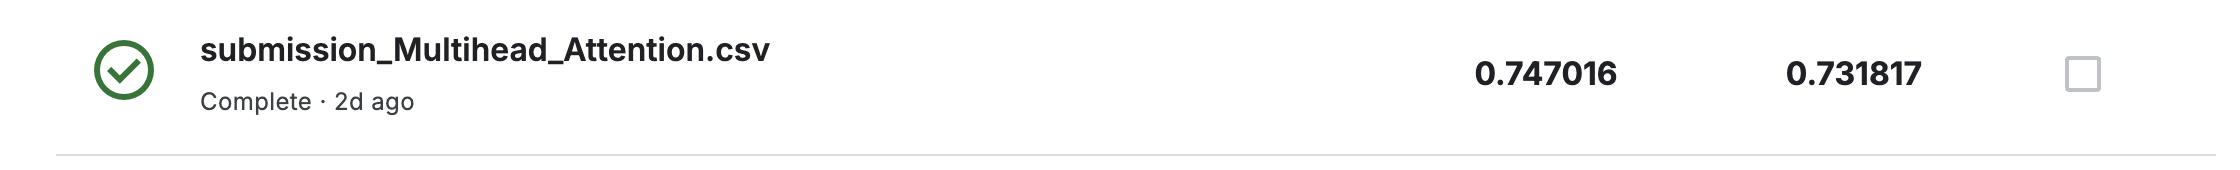

------

# Часть 2 - дообучение готовых моделей

 # 1. Эмбединги sergeyzh/rubert-mini-frida

 https://huggingface.co/sergeyzh/rubert-mini-frida

Вместо этого я решила попробовать поработать над улучшением модели Multihead Attention, добавив к ней качественные предобученные эмбеддинги:

- Использована специализированная модель sergeyzh/rubert-mini-frida (HuggingFace)
- Полученные эмбеддинги объединены с тем, получили на TF-IDF


https://huggingface.co/sergeyzh/rubert-mini-frida

In [ ]:
MODEL_NAME = "sergeyzh/rubert-mini-frida"
MAX_LEN = 128
BATCH_SIZE = 64
EPOCHS = 5
LR = 2e-5
N_SPLITS = 5

 ### 1.1 Загрузка модели и токенизатора  rubert-mini-frida

In [ ]:
# Загрузка модели и токенизатора

MODEL_NAME = "sergeyzh/rubert-mini-frida"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()  # обязательно!

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(83828, 312, padding_idx=0)
    (position_embeddings): Embedding(2048, 312)
    (token_type_embeddings): Embedding(2, 312)
    (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-6): 7 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=312, out_features=312, bias=True)
            (key): Linear(in_features=312, out_features=312, bias=True)
            (value): Linear(in_features=312, out_features=312, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=312, out_features=312, bias=True)
            (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)

In [ ]:
 # Функция для mean-pooling
def mean_pooling(hidden_state, attention_mask):
    """
    Применяет mean pooling к последнему скрытому состоянию.
    """
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_state.size()).float()
    return torch.sum(hidden_state * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [ ]:
# Подготовка текста для BERT
# Объединим важные поля: title, skills, description

# Это мой сохраненный выше df_for_bert , который только часть train (val отложен)
df_for_bert_full = df_for_bert.copy()

# Заполняем пропуски
df_for_bert_full['skills'] = df_for_bert_full['skills'].fillna('')
df_for_bert_full['description'] = df_for_bert_full['description'].fillna('')

# Объединяем текст
df_for_bert_full['text'] = (
    df_for_bert_full['title'] + " [SEP] " +
    df_for_bert_full['skills'] + " [SEP] " +
    df_for_bert_full['description']
)

In [ ]:
# Функция извлечения эмбеддингов

def get_frida_embeddings(texts, batch_size=64, max_len=128):
    embeddings = []
    device = next(model.parameters()).device

    for i in tqdm(range(0, len(texts), batch_size), desc="Извлечение эмбеддингов"):
        batch_texts = texts[i:i+batch_size]
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_len,
            return_tensors='pt'
        ).to(device)

        with torch.no_grad():
            outputs = model(**encoded)
            # Mean pooling
            pooled = mean_pooling(outputs.last_hidden_state, encoded['attention_mask'])
            # Нормализация L2 (по умолчанию в примере)
            pooled = torch.nn.functional.normalize(pooled, p=2, dim=1)
            embeddings.append(pooled.cpu().numpy())

    return np.vstack(embeddings)

In [ ]:
# Извлечение эмбеддингов для train , val и test
# Для train
train_texts = df_for_bert_full['text'].tolist()
train_frida_emb = get_frida_embeddings(train_texts)

# Для val
val_texts = (
    val_df['title'] + " [SEP] " +
    val_df['skills'].fillna('') + " [SEP] " +
    val_df['description'].fillna('')
).tolist()
val_frida_emb = get_frida_embeddings(val_texts)


# Для test
test_texts = (
    test_df['title'] + " [SEP] " +
    test_df['skills'].fillna('') + " [SEP] " +
    test_df['description'].fillna('')
).tolist()
test_frida_emb = get_frida_embeddings(test_texts)

print("Размер эмбеддингов (train):", train_frida_emb.shape)  # (N, 312)
print("Размер эмбеддингов (val):", val_frida_emb.shape)    # (M, 312)
print("Размер эмбеддингов (test):", test_frida_emb.shape)    # (M, 312)

Извлечение эмбеддингов: 100%|██████████| 87/87 [00:02<00:00, 41.97it/s]

Размер эмбеддингов (train): (13333, 312)
Размер эмбеддингов (val): (3334, 312)
Размер эмбеддингов (test): (5556, 312)


### 1.2 Объединение с TF-IDF + experience
Теперь у нас есть:

X_all — первоначальный разреженный TF-IDF + experience (размер ~8000–10000 признаков)
train_frida_emb, test_frida_emb — плотные эмбеддинги (312)

Нужно:
- Нормализовать эмбеддинги
- Конвертировать в csr_matrix
- Приклеить к X_all

In [ ]:
# 1. Нормализуем эмбеддинги (можно, но не обязательно — они уже нормализованы)
# scaler_frida = StandardScaler()
# train_frida_emb = scaler_frida.fit_transform(train_frida_emb)
# test_frida_emb = scaler_frida.transform(test_frida_emb)

# 2. Конвертируем в sparse-матрицу
# После извлечения эмбеддингов
train_frida_sparse = csr_matrix(train_frida_emb)   # (13333, 312)
val_frida_sparse = csr_matrix(val_frida_emb)       # (3334, 312)
test_frida_sparse = csr_matrix(test_frida_emb)     # (5556, 312)

# 3. Объединяем с моими признаками
X_all_enhanced = hstack([X_all, train_frida_sparse])     # (13333, 10320)
X_val_enhanced = hstack([X_val_all, val_frida_sparse])   # (3334, 10320)
X_test_enhanced = hstack([X_test_all, test_frida_sparse]) # (5556, 10320)


print("Размер расширенной матрицы (train):", X_all_enhanced.shape)
print("Размер расширенной матрицы (val):", X_val_enhanced.shape)
print("Размер расширенной матрицы (test):", X_test_enhanced.shape)



Размер расширенной матрицы (train): (13333, 10320)
Размер расширенной матрицы (val): (3334, 10320)
Размер расширенной матрицы (test): (5556, 10320)


### 1.3 Обучение модели SalaryRegressorWithAttention на расширенных признаках


In [ ]:
# Создаём датасет
train_ds = SalaryDataset(X_all_enhanced, y_all, scaler.mean_[0], scaler.scale_[0])
test_ds = SalaryDataset(X_test_enhanced, exp_mean=scaler.mean_[0], exp_std=scaler.scale_[0])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=512)

# Создаём модель с новой размерностью
enhanced_model = SalaryRegressorWithAttention(
    input_dim=X_all_enhanced.shape[1],  # теперь больше!
    hidden_size1=768,
    hidden_size2=192,
    hidden_size3=160,
    dropout=0.375,
    num_heads=8,
    attn_dropout=0.0858
).to(device)

optimizer = torch.optim.AdamW(enhanced_model.parameters(), lr=1.239e-4, weight_decay=1e-4)
loss_fn = nn.MSELoss()

# Обучаем (20 эпох, с ранней остановкой)
best_r2 = -np.inf
for epoch in range(20):
    enhanced_model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = enhanced_model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()

    # Валидация
    enhanced_model.eval()
    val_preds = []
    with torch.no_grad():
        for xb, yb in val_loader:  # это первоначальный val_loader из предыдущего кода
            xb = xb.to(device)
            pred = enhanced_model(xb).cpu().numpy()
            val_preds.extend(pred)

    val_r2 = r2_score(val_df['log_salary_from'], val_preds)
    print(f"Epoch {epoch+1}, Val R²: {val_r2:.4f}")

    if val_r2 > best_r2:
        best_r2 = val_r2
        torch.save(enhanced_model.state_dict(), 'best_enhanced_model.pth')

print(f"✅ Лучший R²: {best_r2:.4f}")

Epoch 1, Val R²: 0.6162
Epoch 2, Val R²: 0.6935
Epoch 3, Val R²: 0.6845
Epoch 4, Val R²: 0.7217
Epoch 5, Val R²: 0.7122
Epoch 6, Val R²: 0.7041
Epoch 7, Val R²: 0.7250
Epoch 8, Val R²: 0.7245
Epoch 9, Val R²: 0.7204
Epoch 10, Val R²: 0.7292
Epoch 11, Val R²: 0.7244
Epoch 12, Val R²: 0.7207
Epoch 13, Val R²: 0.7214
Epoch 14, Val R²: 0.7303
Epoch 15, Val R²: 0.7382
Epoch 16, Val R²: 0.7315
Epoch 17, Val R²: 0.7271
Epoch 18, Val R²: 0.7315
Epoch 19, Val R²: 0.7131
Epoch 20, Val R²: 0.7293
✅ Лучший R²: 0.7382


### ИНФЕРЕНС  SalaryRegressorWithAttention на расширенных признаках frida

In [ ]:
# Создаём модель с правильной размерностью
enhanced_model = SalaryRegressorWithAttention(
    input_dim=X_all_enhanced.shape[1],  # 10320
    hidden_size1=768,
    hidden_size2=192,
    hidden_size3=160,
    dropout=0.375,
    num_heads=8,
    attn_dropout=0.0858
).to(device)

# Загружаем лучшие веса
enhanced_model.load_state_dict(torch.load('best_enhanced_model.pth', map_location=device))
enhanced_model.eval()  # Обязательно!

SalaryRegressorWithAttention(
  (fc1): Linear(in_features=10320, out_features=768, bias=True)
  (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (attn_ln): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=768, out_features=192, bias=True)
  (ln2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  (fc_res): Linear(in_features=768, out_features=192, bias=True)
  (fc3): Linear(in_features=192, out_features=160, bias=True)
  (ln3): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.375, inplace=False)
  (fc_out): Linear(in_features=160, out_features=1, bias=True)
)

In [ ]:
# test_loader уже создан ранее
# Если нет — создай:
# test_ds = SalaryDataset(X_test_enhanced, exp_mean=scaler.mean_[0], exp_std=scaler.scale_[0])
# test_loader = DataLoader(test_ds, batch_size=512, shuffle=False)

# Предсказания
final_test_preds = []
with torch.no_grad():
    for xb in test_loader:
        xb = xb.to(device)
        pred = enhanced_model(xb)
        final_test_preds.extend(pred.cpu().numpy())

final_test_preds = np.array(final_test_preds)

In [ ]:
# Создание submission
submission = pd.DataFrame({
    'prediction': final_test_preds
}).reset_index().rename(columns={'index': 'index'})

submission.to_csv('submission_frida_enhanced.csv', index=False)
print("✅ Файл 'submission_frida_enhanced.csv' успешно сохранён!")

✅ Файл 'submission_frida_enhanced.csv' успешно сохранён!


Таким образом за счет эмбедингов удалось улучшить результат модели на 0.01! !

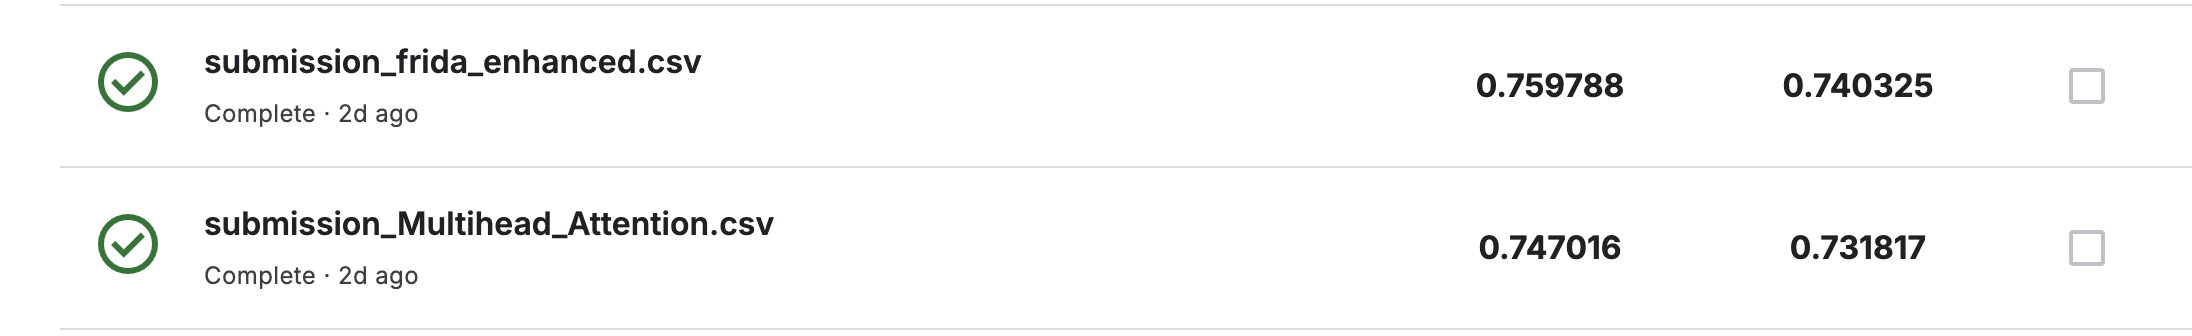

# 2. Fine-tuning  ruBERT

## 2.1 Загрузка и исследование модели и токинайзера sberbank-ai/ruBERT-tiny

In [ ]:
# 1. Отключаем предупреждения Python
warnings.filterwarnings('ignore')

# 2. Отключаем логи Hugging Face Transformers
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # Убирает ворнинги при токенизации

# 3. Настройка logging
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("datasets").setLevel(logging.ERROR)
logging.getLogger("urllib3").setLevel(logging.ERROR)
logging.getLogger("torch").setLevel(logging.ERROR)

In [ ]:
# 4. Объединение текста
def combine_text(row):
    return (
        f"ДОЛЖНОСТЬ: {row['title_processed']} [SEP] "
        f"НАВЫКИ: {row['skills_processed']} [SEP] "
        f"ОПИСАНИЕ: {row['description_processed']}"
    )

train_texts = df_for_bert.apply(combine_text, axis=1).tolist()
val_texts = val_df.apply(combine_text, axis=1).tolist()
test_texts = test_df.apply(combine_text, axis=1).tolist()


In [ ]:
# 5. Загрузка модели

MODEL_NAME = "sberbank-ai/ruBERT-tiny"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=1,
    problem_type="regression"
).to(device)

In [ ]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
# Посмитрим общее число параметров
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Общее число параметров: {total:,}")
    print(f"Обучаемых параметров: {trainable:,}")
    return total, trainable

count_parameters(model)

Общее число параметров: 178,308,097
Обучаемых параметров: 178,308,097


(178308097, 178308097)

In [ ]:
# Визуализация: граф архитектуры
from torchviz import make_dot

# Примерный батч
batch = tokenizer(
    ["Тестовая вакансия"],
    return_tensors='pt',
    padding=True,
    truncation=True,
    max_length=128
).to(device)

# Прямой проход
output = model(**batch)

# Визуализация
dot = make_dot(output.logits, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('bert_architecture', cleanup=True)  # Сохранит как bert_architecture.png

'bert_architecture.png'

In [ ]:
# Информация о токенизаторе
print("Vocab size:", tokenizer.vocab_size)           # ~120138
print("Model max length:", tokenizer.model_max_length)  # 512
print("Special tokens:", tokenizer.special_tokens_map)  # [CLS], [SEP], [PAD]

Vocab size: 120138
Model max length: 1000000000000000019884624838656
Special tokens: {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}


## 2.2 Модифицированная модель  CustomRuBertForRegression с улучшенным классификатором

In [ ]:
# 1. Голова с улучшенным классификатором

class CustomRuBertForRegression(AutoModelForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        # Заменяем стандартный классификатор на более сложный
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )
        self.init_weights()


In [ ]:
# Проверяем загрузку модели
MODEL_NAME = "sberbank-ai/ruBERT-tiny"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Инициализируем конфиг и модифицируем его
from transformers import BertConfig
config = BertConfig.from_pretrained(MODEL_NAME)
config.num_labels = 1
config.problem_type = "regression"
config.hidden_dropout_prob = 0.2
config.attention_probs_dropout_prob = 0.2

model = CustomRuBertForRegression.from_pretrained(
    MODEL_NAME,
    config=config
).to(device)

### Подготовка датасетов

In [ ]:
# Подготовка датасетов под параметры ruBERT-tiny

MAX_LEN = 512

train_data = pd.DataFrame({'text': train_texts, 'label': df_for_bert['log_salary_from'].values})
val_data = pd.DataFrame({'text': val_texts, 'label': val_df['log_salary_from'].values})

train_hf = HFDataset.from_pandas(train_data)
val_hf = HFDataset.from_pandas(val_data)

def tokenize(batch):
    return tokenizer(
        batch['text'],
        padding='max_length',
        truncation=True,
        max_length=MAX_LEN,
        return_tensors='pt',
        add_special_tokens=True
    )

train_hf = train_hf.map(tokenize, batched=True, batch_size=1000)
val_hf = val_hf.map(tokenize, batched=True, batch_size=1000)

train_hf.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_hf.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])


In [ ]:
# Расширенные метрики
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.flatten()
    return {
        "r2": r2_score(labels, predictions),
    }


### Оптимизированные параметры обучения

In [ ]:
# Оптимизированные параметры обучения
training_args = TrainingArguments(
    output_dir='./results_rubert_improved',
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    warmup_steps=500,
    weight_decay=0.001,
    logging_dir='./logs',
    logging_strategy="epoch",  # Только логирование по эпохам
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="r2",
    greater_is_better=True,
    report_to="none",  # Отключаем все сторонние отчеты
    learning_rate=3e-5,
    save_total_limit=2,
    seed=RANDOM_STATE,
    dataloader_num_workers=4,
    fp16=True,
    gradient_checkpointing=True,
    optim="adamw_torch",
    disable_tqdm=False,  # Включаем прогресс-бар
    logging_steps=None,  # Отключаем логирование по шагам
)


# Trainer с ранней остановкой
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.001
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_hf,
    eval_dataset=val_hf,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

## 2.3 Дообучение ruBERT-tiny с рукописным классификатором

In [ ]:
# Обучение с выводом метрик

print("🚀 Начинаем улучшенное дообучение ruBERT...")
train_results = trainer.train()

# Сохраняем метрики обучения
metrics = train_results.metrics
trainer.save_metrics("train", metrics)
trainer.save_model("./best_rubert_regression")


# Оценка и сохранение лучшей модели
print("\n⭐ Оценка на валидационной выборке:")
eval_results = trainer.evaluate(eval_dataset=val_hf)

# Красивый вывод метрик
print("\n=== Результаты ===")
print(f"✅ R²: {eval_results['eval_r2']:.4f}")


# Сохраняем лучшую модель
trainer.save_model("./best_rubert_regression")
tokenizer.save_pretrained("./best_rubert_regression")

# Дополнительно: сохраняем все метрики в файл
with open("./best_rubert_regression/eval_results.txt", "w") as f:
    f.write(f"R²: {eval_results['eval_r2']:.4f}\n")

Map:   0%|          | 0/13333 [00:00<?, ? examples/s]

Map:   0%|          | 0/3334 [00:00<?, ? examples/s]

🚀 Начинаем улучшенное дообучение ruBERT...


Epoch,Training Loss,Validation Loss,R2
1,2.729200,0.179415,0.534258
2,0.190400,0.150392,0.609597
3,0.153600,0.164199,0.573757
4,0.121800,0.130135,0.662184
5,0.106500,0.138851,0.639558
6,0.091200,0.137315,0.643544



⭐ Оценка на валидационной выборке:



=== Результаты ===
✅ R²: 0.6622


In [ ]:
#  Оценка на val
eval_results = trainer.evaluate()
r2_val = eval_results['eval_r2']
print(f"✅ R² на val: {r2_val:.4f}")

✅ R² на val: 0.6622


## ИНФЕРЕНС  ruBERT-tiny на test

In [ ]:
# Инференс на test

print(f"✅ R² на val: {r2_val:.4f}")

test_data = pd.DataFrame({'text': test_texts})
test_hf = HFDataset.from_pandas(test_data)
test_hf = test_hf.map(tokenize, batched=True, batch_size=1000)
test_hf.set_format('torch', columns=['input_ids', 'attention_mask'])

predictions = trainer.predict(test_hf)
preds_bert = predictions.predictions.flatten()


# Post-process: ограничение пределов
# preds_bert = np.clip(preds_bert, 3.9, 6.9)  # log(50k) ~ 3.9, log(1M) ~ 6.9


# Создание submission
submission = pd.DataFrame({
    'prediction': preds_bert
}).reset_index().rename(columns={'index': 'index'})

submission.to_csv('submission_rubert_base.csv', index=False)
print("✅ Файл 'submission_rubert_base.csv' сохранён!")



✅ R² на val: 0.6622


Map:   0%|          | 0/5556 [00:00<?, ? examples/s]

✅ Файл 'submission_rubert_base.csv' сохранён!


На этот момент у меня оставалась только одна посылка, поэтому я решила сразу усилить результат ансамблированием

----

# Часть 3 Ансамблирование

# 3.1 Финальный Ансамбль из 2 моделей
Рукописная модель SalaryRegressorWithAttention с эмбедингами  frida_enhanced и  ruBERT-tiny

In [ ]:
# Загружаем submission_frida_enhanced

try:
    sub_mlp = pd.read_csv('submission_frida_enhanced.csv')
    preds_mlp = sub_mlp['prediction'].values
    alpha = 0.6
    final_preds = alpha * preds_mlp + (1 - alpha) * preds_bert
    print(f"✅ Ансамбль: {alpha:.1f}*MLP + {1-alpha:.1f}*BERT")
except:
    print("⚠️ Файл submission_frida_enhanced.csv не найден. Используем только BERT.")
    final_preds = preds_bert


# Финальный submission

# Создание submission
final_submission = pd.DataFrame({
    'prediction': final_preds
}).reset_index().rename(columns={'index': 'index'})


final_submission.to_csv('submission_ensemble_final.csv', index=False)
print("✅ Финальный submission сохранён: submission_ensemble_final.csv")


# Итог

print(f"✅ R² на val: {r2_val:.4f}")
print(f"✅ Форма предсказаний: {final_preds.shape}")
print("🎉 Готово! Можете отправлять на лидерборд.")

✅ R² на val: 0.6622


Map:   0%|          | 0/5556 [00:00<?, ? examples/s]

✅ Ансамбль: 0.6*MLP + 0.4*BERT
✅ Финальный submission сохранён: submission_ensemble_final.csv
✅ R² на val: 0.6622
✅ Форма предсказаний: (5556,)
🎉 Готово! Можете отправлять на лидерборд.


Таким образом получилось еще улучшить результат

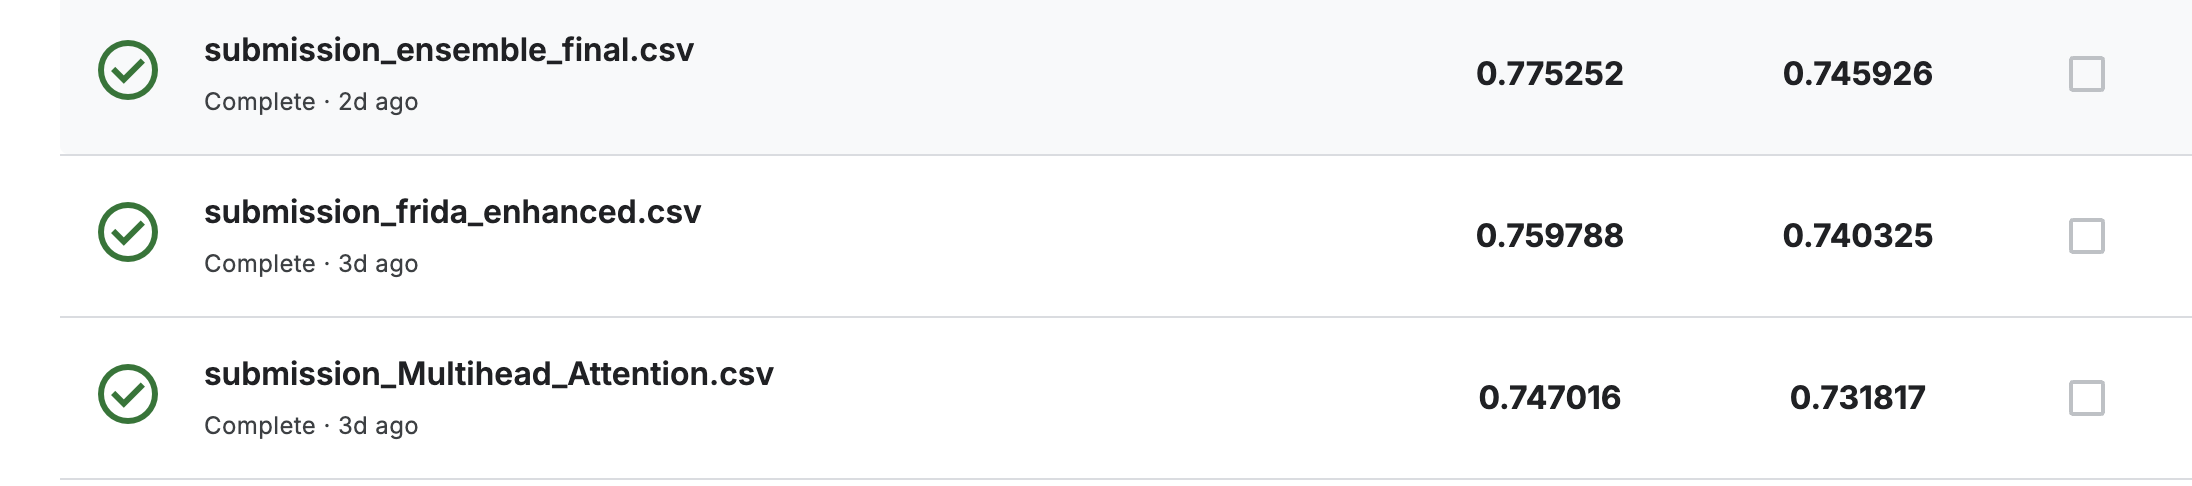

# 3.2 Улучшенный ансамбль: взвешенная комбинация из 3 моделей

Была еще попытка улучшить результат, но она была лучшей только до обьявления всех результатов

###  3.2.1 OOF для Multihead_Attention (MLP)

In [ ]:
# Предположим, что у тебя есть векторизаторы и scaler из предыдущего обучения
# Если нет — тебе нужно пересоздать X_val_all (аналогично train)

# Пример: как получить X_val_all (если ты не сохранила)
# (Это кратко — в реальности у тебя уже есть векторизаторы)
X_val_tfidf = []
for col, vectorizer in vectorizers.items():
    vec = vectorizer.transform(val_df[f'{col}_processed'])
    X_val_tfidf.append(vec)
X_val_sparse = hstack(X_val_tfidf)
X_val_num = val_df[['experience_from']].values
X_val_num_scaled = scaler.transform(X_val_num)
X_val_all = hstack([X_val_sparse, csr_matrix(X_val_num_scaled)])

# Загружаем лучшую рукописную модель
model_mlp = SalaryRegressorWithAttention(
    input_dim=X_val_all.shape[1],
    hidden_size1=768,
    hidden_size2=192,
    hidden_size3=160,
    dropout=0.375,
    num_heads=8,
    attn_dropout=0.0858
).to(device)

# Загружаем веса
model_mlp.load_state_dict(torch.load('best_model_weights.pth', map_location=device))
model_mlp.eval()

# Инференс на val
val_dataset = SalaryDataset(X_val_all, y_val_true, scaler.mean_[0], scaler.scale_[0])
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

preds_mlp_val = []
with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(device)
        pred = model_mlp(xb)
        preds_mlp_val.extend(pred.cpu().numpy())
preds_mlp_val = np.array(preds_mlp_val)

###  3.2.2 OOF для frida_enhanced

In [ ]:
# Убедись, что X_val_enhanced построена аналогично X_all_enhanced
# Если ты её не сохранила — построй заново (TF-IDF + FRIDA-эмбеддинги)

# Пример (если у тебя есть X_val_enhanced):
val_ds_enhanced = SalaryDataset(X_val_enhanced, y_val_true, scaler.mean_[0], scaler.scale_[0])
val_loader_enhanced = DataLoader(val_ds_enhanced, batch_size=512)

# Загружаем модель
enhanced_model = SalaryRegressorWithAttention(
    input_dim=X_val_enhanced.shape[1],
    hidden_size1=768,
    hidden_size2=192,
    hidden_size3=160,
    dropout=0.375,
    num_heads=8,
    attn_dropout=0.0858
).to(device)

enhanced_model.load_state_dict(torch.load('best_enhanced_model.pth', map_location=device))
enhanced_model.eval()

preds_frida_val = []
with torch.no_grad():
    for xb, _ in val_loader_enhanced:
        xb = xb.to(device)
        pred = enhanced_model(xb)
        preds_frida_val.extend(pred.cpu().numpy())
preds_frida_val = np.array(preds_frida_val)

###  3.2.3 OOF для ruBERT-base

In [ ]:
# Убедись, что у тебя есть preds_bert_val (предсказания на val)
# Если нет — сделай инференс:

# (Предполагается, что у тебя уже есть tokenizer, model, val_texts)
val_data = pd.DataFrame({'text': val_texts, 'label': y_val_true})
val_hf = HFDataset.from_pandas(val_data)
val_hf = val_hf.map(tokenize_with_error_handling, batched=True, load_from_cache_file=False)
val_hf.set_format('torch', columns=['input_ids', 'attention_mask'])

# Инференс
predictions = trainer.predict(val_hf)
preds_bert_val = predictions.predictions.flatten()

Map:   0%|          | 0/3334 [00:00<?, ? examples/s]

## 3.2.3 Обучаем мета-модель (Ridge) на OOF-предсказаниях

In [ ]:
# Собираем OOF-предсказания в матрицу
X_oof = np.column_stack([preds_mlp_val, preds_frida_val, preds_bert_val])

# Обучаем Ridge с положительными весами
meta_model = Ridge(alpha=1.0, positive=True)
meta_model.fit(X_oof, y_val_true)

# Получаем веса
w1, w2, w3 = meta_model.coef_
intercept = meta_model.intercept_

print(f"✅ Веса от Ridge: MLP={w1:.3f}, Frida={w2:.3f}, BERT={w3:.3f}")
print(f"✅ Intercept: {intercept:.4f}")

# R² на val
r2_oof = r2_score(y_val_true, meta_model.predict(X_oof))
print(f"✅ R² на val (ансамбль): {r2_oof:.4f}")

✅ Веса от Ridge: MLP=0.368, Frida=0.360, BERT=0.301
✅ Intercept: -0.1603
✅ R² на val (ансамбль): 0.7621


## 3.2.4 Инференс на test с оптимальными весами

In [ ]:
# Загружаем предсказания на test
sub_mlp = pd.read_csv('submission_Multihead_Attention.csv')
sub_frida = pd.read_csv('submission_frida_enhanced.csv')
sub_bert = pd.read_csv('submission_rubert_base.csv')

preds_mlp = sub_mlp['prediction'].values
preds_frida = sub_frida['prediction'].values
preds_bert = sub_bert['prediction'].values  # или 'log_salary_from'

# Применяем найденные веса
final_preds = w1 * preds_mlp + w2 * preds_frida + w3 * preds_bert + intercept

# Post-process: ограничение диапазона
final_preds = np.clip(final_preds, 3.9, 6.9)  # log(50k) ~ 3.9, log(1M) ~ 6.9

## 3.2.5 Сохранение финального submission

In [ ]:
# Сохраняем

# Создание submission
submission = pd.DataFrame({
    'prediction': final_preds
}).reset_index().rename(columns={'index': 'index'})

submission.to_csv('submission_best_ensemble_final.csv', index=False)
print("✅ Файл 'submission_best_ensemble_final.csv' сохранён!")



print("✅ Финальный submission сохранён: submission_ensemble_final.csv")

# Проверка
print(f"Форма: {submission.shape}")
print(f"Среднее: {final_preds.mean():.4f}, Min: {final_preds.min():.4f}, Max: {final_preds.max():.4f}")

✅ Файл 'submission_best_ensemble_final.csv' сохранён!
✅ Финальный submission сохранён: submission_ensemble_final.csv
Форма: (5556, 2)
Среднее: 4.5344, Min: 3.9000, Max: 5.9153


ИТОГ на Private Score 0.768170 , он оказался чуть слобее предыдущего ансамля из двух моделей

![Снимок экрана 2025-07-27 в 08.47.05.png](attachment:bda7f9a7-70f6-4c92-b0d7-01444a000363.png)

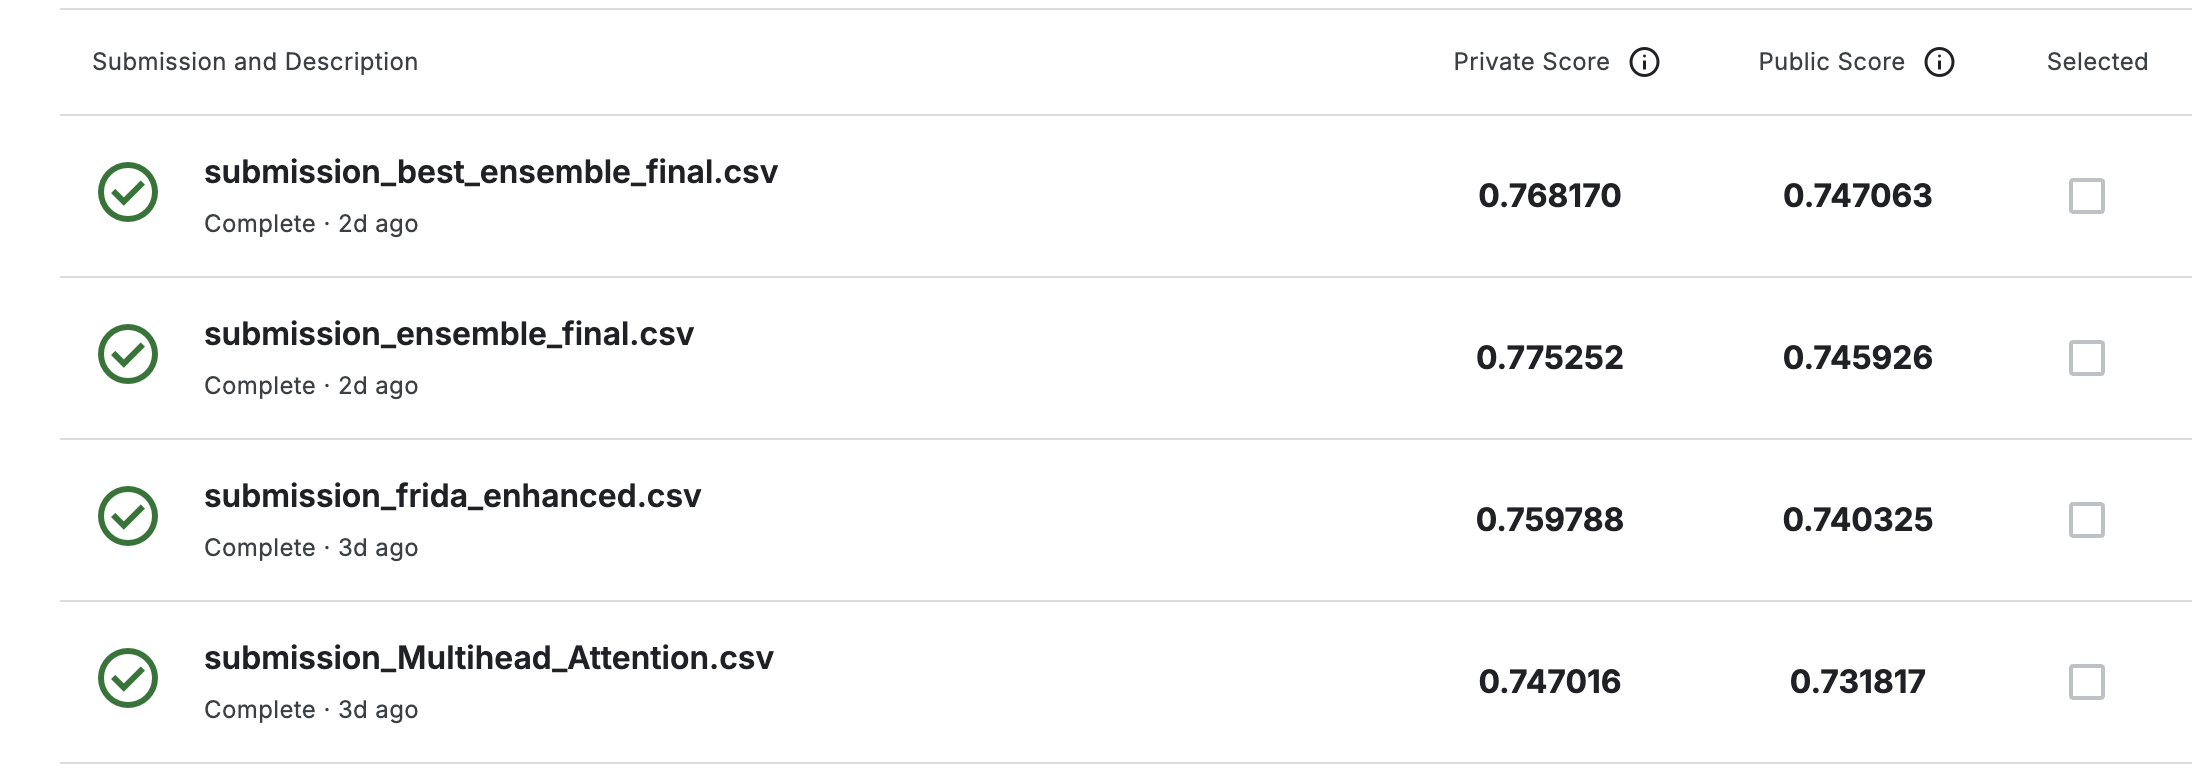